## 写在开头
学习目标：利用Home Credit提供的历史贷款数据预测贷款人是否会偿还贷款  
任务类型：这是一个典型的有监督二分类任务。（0表示偿还了贷款，1表示没有偿还贷款）  
评价指标：area under ROC curve

## 数据
数据共有7种：
- application_{train|test}.csv：
    - 这是主要的训练集和测试集数据
    - 每一行代表一个贷款的统计数据
- bureau.csv：
    - 这是外部数据
    - 每一行代表一位贷款申请人的补充数据，数据由外部机构提供给Credit Bureau
    - 这些数据来自申请贷款之前
- bureau_balance.csv：
    - 这份数据记录了Creadit Bureau中之前贷款的每月账单余额
- POS_CASH_balance.csv：
    - 这份数据记录了贷款申请人之前在Home Credit贷款（POS和现金贷）的每月余额情况
- previous_application.csv：
    - 贷款人所有以前向Home Credit提交的贷款申请
- installments_payments.csv：
    - 之前从Home Credit贷款的还款记录


各数据间的相关关系如下：
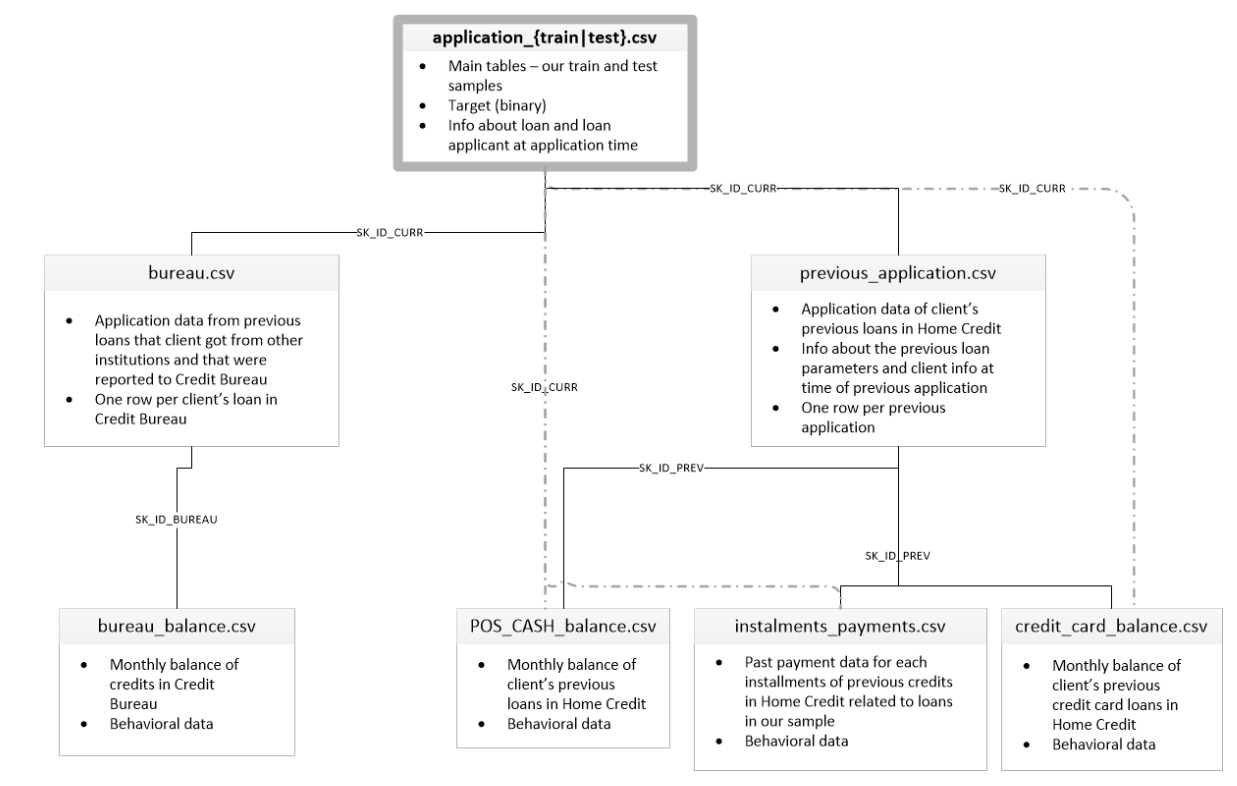

## 载入处理包

In [1]:
# 数据操作
import numpy as np
import pandas as pd

# 文件管理
import os

# 过滤警告
import warnings
warnings.filterwarnings('ignore')

# 绘图
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
matplotlib_style = 'fivethirtyeight' #@param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']
plt.style.use(matplotlib_style)
import seaborn as sns
sns.set_context('notebook')
%matplotlib inline
from IPython.core.pylabtools import figsize
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
%config InlineBackend.figure_format = notebook_screen_res

## 读取数据

In [2]:
# 列出数据文件，方便复制粘贴
print(os.listdir('./datasets'))

['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']


In [3]:
# 读取训练数据
filePath = './datasets/'
trainFileName = 'application_train.csv'
testFileName = 'application_test.csv'
train = pd.read_csv(filePath + trainFileName)
test = pd.read_csv(filePath + testFileName)
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [5]:
def rows_cols(df is pd.DataFrame) =
    rows, cols = df.shape
    print(f"number of rows: {rows}")
    print(f"number of columns: {cols}")

# (train.shape 
# |> (def (x) -> 
#          rows, cols = x;
#          print(f"# of rows: {rows}");
#          print(f"# of columns: {cols}")))

rows_cols(train)
rows_cols(test)

number of rows: 307511
number of columns: 122
number of rows: 48744
number of columns: 121


## EDA探索性数据

首先看看Target（我们的预测目标的分布情况）：

Text(0.5, 1.0, 'Target分布情况')

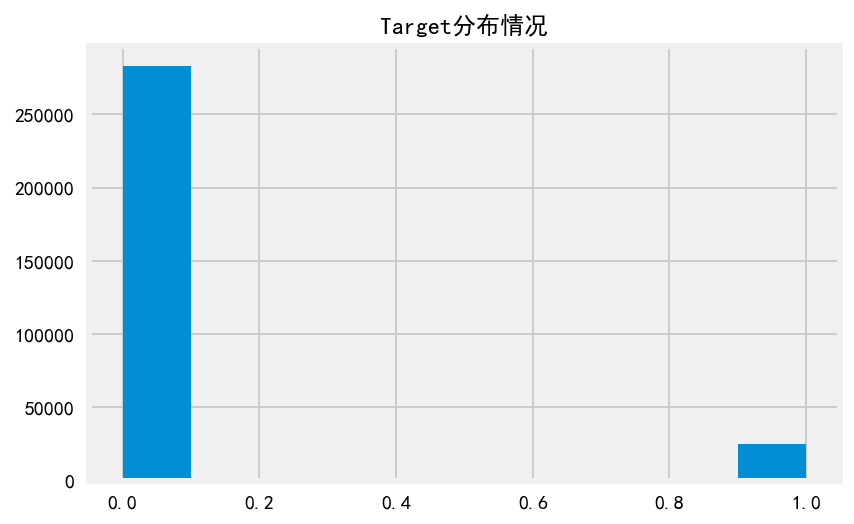

In [6]:
train['TARGET'].hist()
plt.title("Target分布情况")

In [7]:
train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

预测目标的分布非常不均衡，需要在后续进行处理。

### 检查缺失值

In [8]:
import attr
import pandas as pd
from toolz import pipe
from toolz.curried import *
from prettytable import PrettyTable

@attr.s()
class MissingValueTable(object):

    df = attr.ib()

    @property
    def missingValues(self):
        return self.df.isnull().sum()
    
    @property
    def missingValuePercent(self):
        return 100 * self.missingValues / len(self.df)

    @property
    def missingValueTable(self):
        return pipe(
            [self.missingValues, self.missingValuePercent],
            curry(pd.concat, axis=1),
            lambda x: x.rename(
            columns = {0:'Missing Values', 1:'% of Total Values'}
            ),
            lambda x: x[x.iloc[:, 1] != 0].sort_values(
                '% of Total Values', ascending = False
            ).round(1)
        )
    
    def missingDescript(self):
        totalCols = len(self.df.columns)
        totalMissingCols = self.missingValueTable.shape[0]
        missingPercentage = round(100 * totalMissingCols / totalCols, 1)
        ptable = PrettyTable(["Item", "Rows"])
        ptable.align["Item"] = "l"
        ptable.add_row(["total columns", totalCols])
        ptable.add_row(["total missing columns", totalMissingCols])
        ptable.add_row(["total missing percentage", str(missingPercentage) + "%"])
        print(ptable)

In [9]:
mis = MissingValueTable(train)

In [10]:
mis.missingDescript()
mis.missingValueTable.head(20)

+--------------------------+-------+
| Item                     |  Rows |
+--------------------------+-------+
| total columns            |  122  |
| total missing columns    |   67  |
| total missing percentage | 54.9% |
+--------------------------+-------+


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


可以看到缺失的比例很大，有很多字段缺失比例甚至高达60%。  
后续需要对确实值，进行处理，或者使用对缺失值不敏感的模型。

## 看一下字段的种类

In [11]:
train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [12]:
train.select_dtypes('object').apply(pd.Series.nunique)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [13]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()


In [14]:
train2 = train.copy()
test2 = test.copy()

for col in train2.columns.values:
    if train2[col].dtype == 'object' and train2[col].unique() |> len <=2:
        le.fit(train2[col])
        train2[col] = le.transform(train2[col])
        test2[col] = le.transform(test2[col])

In [15]:
train2 = train2 |> pd.get_dummies
test2 = test2 |> pd.get_dummies

In [16]:
print(f"编码后 train shape：{train2.shape}")
print(f"编码后test shape：{test2.shape}")

编码后 train shape：(307511, 243)
编码后test shape：(48744, 239)


训练集和测试集独热编码后的特征居然相差了5，考虑到其中一个是预测目标target，那还多出了4个  
我们看看多出来的是什么：

In [17]:
(train2.columns
 |> filter$(def (_) -> _ not in test2.columns)
 |> map$(print) |> consume
)

TARGET
CODE_GENDER_XNA
NAME_INCOME_TYPE_Maternity leave
NAME_FAMILY_STATUS_Unknown


deque([])

我们查一下，这几个没有在测试集中出现的类别代表什么意思

比赛对这些类别没有具体的解释，  
XNA 和 Unknown 应该分别在特征CODE_GENDER和NAME_FAMILY_STATUS中表示缺失值，  
而Maternity leave只是NAME_INCOME_TYPE中的一个工作类别，恰好没有出现在测试集中而已

In [18]:
for i in ['CODE_GENDER', 'NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS']:
    train[i].isnull().sum() |> print

0
0
0


验证了一下，这几个特征确实没有缺失，所以将这几个特征去除，以保证与测试集特征一致

In [19]:
targets = train2['TARGET']

train2, test2 = train2.align(test2, join='inner', axis=1) 
train2['TARGET'] = targets  

In [20]:
train2.shape |> print$("训练集shape：")
test2.shape |> print$("测试集shape：")

训练集shape： (307511, 240)
测试集shape： (48744, 239)


现在除了`TARGET`这个特征，其他的特征都对齐了。

## EDA探索性数据分析

### 异常值检测

主要通过统计数据，查看特征是否存在异常值。

In [24]:
train2['DAYS_BIRTH'].head()

0    -9461
1   -16765
2   -19046
3   -19005
4   -19932
Name: DAYS_BIRTH, dtype: int64

In [25]:
train2['DAYS_BIRTH'].describe()

count    307511.000000
mean     -16036.995067
std        4363.988632
min      -25229.000000
25%      -19682.000000
50%      -15750.000000
75%      -12413.000000
max       -7489.000000
Name: DAYS_BIRTH, dtype: float64

DAYS_BIRTH表示按天计算的年龄，全部被表示成了负数，是因为这是相对于申请日计算的，也就是申请人在申请日前多少天出生的。  
我们转换成年来看看

In [26]:
(train2['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Text(0.5, 1.0, '申请人年龄分布')

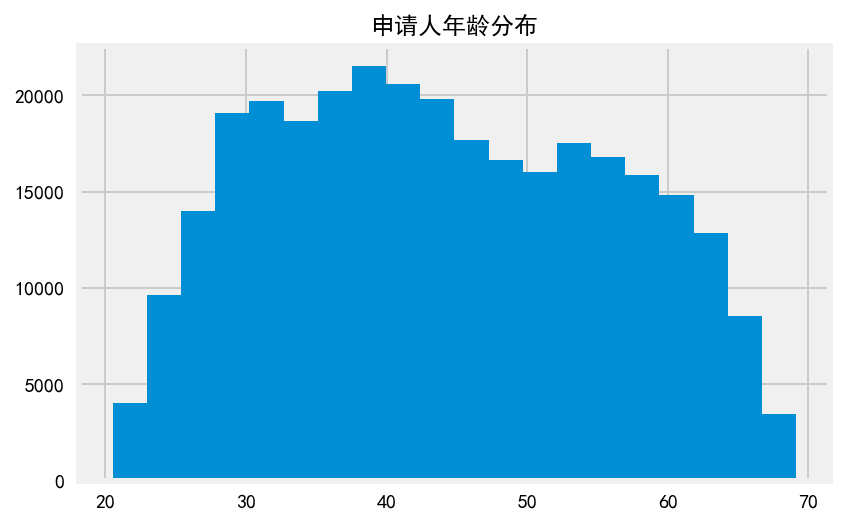

In [29]:
(train2['DAYS_BIRTH'] / -365).hist(bins=20)
plt.title("申请人年龄分布")

年龄分布看起来很正常，没有出现异常值。

再看看

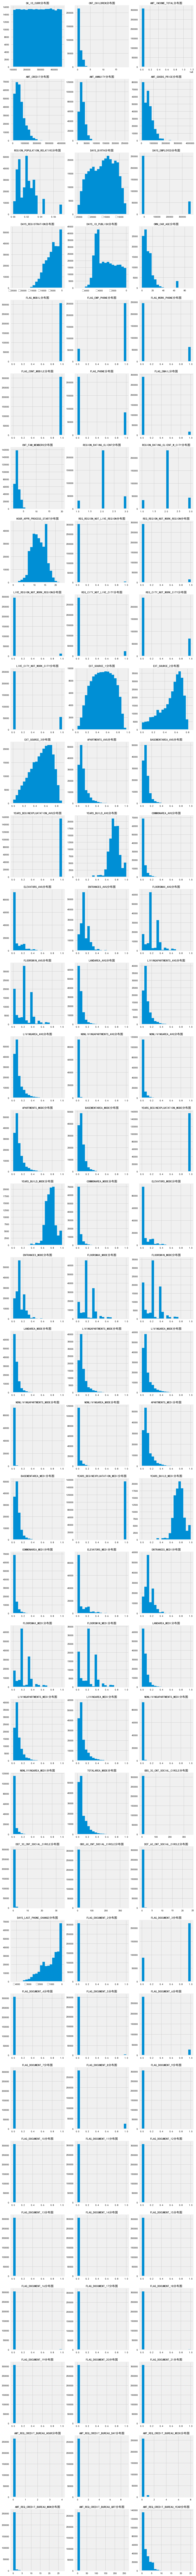

In [122]:
cols = train.drop('TARGET', axis=1).select_dtypes(['float64', 'int64']).columns.values
ncol = 3
nrow = len(cols) / 3 |> int |> (x) -> x + 1
figsize(12, 200)
for i, col in enumerate(cols):
    ax = plt.subplot(nrow,ncol, i+1)
#     ax.set_autoscaley_on(False)
    train[col].hist(bins=20,ax=ax)
    plt.title(col+"分布图")

AMT_INCOME_TOTAL表示申请人的总收入，从上图来看好像所有人的收入都是0一样，那是因为有几个收入达到一千多万的离群值将横轴撑得很宽  
我们不妨看一下具体的分布信息：

In [123]:
train['AMT_INCOME_TOTAL'].describe()

count    3.075110e+05
mean     1.687979e+05
std      2.371231e+05
min      2.565000e+04
25%      1.125000e+05
50%      1.471500e+05
75%      2.025000e+05
max      1.170000e+08
Name: AMT_INCOME_TOTAL, dtype: float64

最大值居然超过一个亿！不知道收入一个亿的人为啥要贷款  
取75%收入水平以下的数据重新绘制直方图：

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


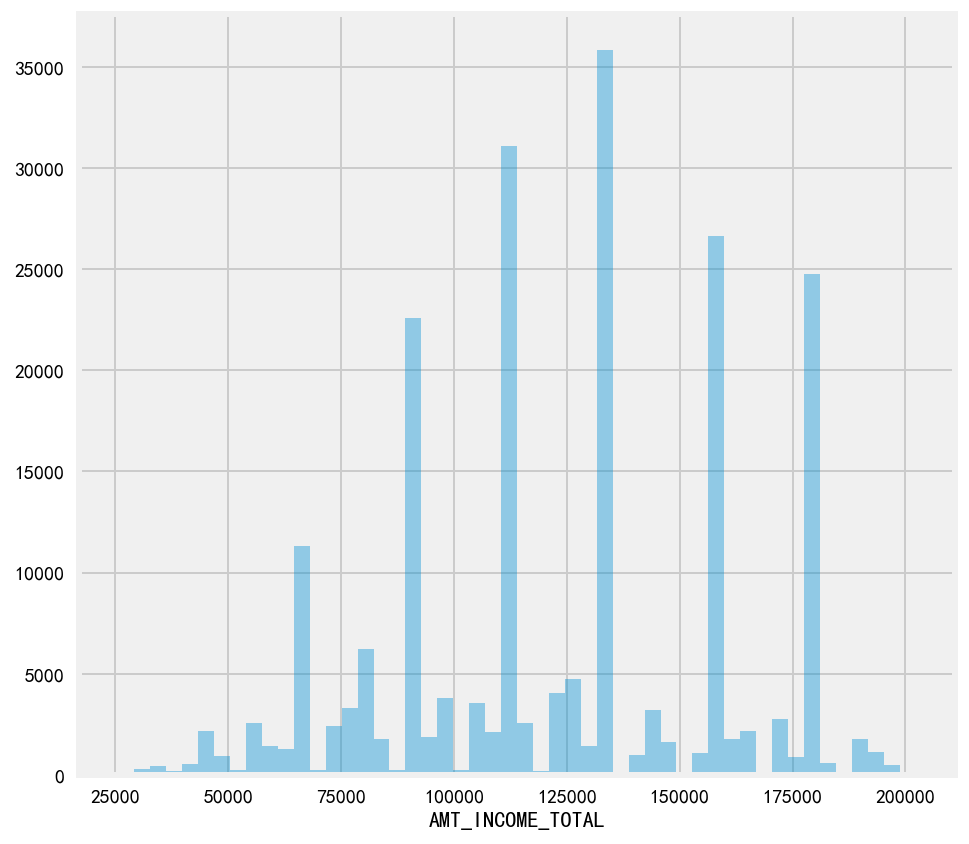

In [138]:
figsize(7,7)
(train.loc[train['AMT_INCOME_TOTAL'] < 2.025000e+05 ,'AMT_INCOME_TOTAL'] |>
    sns.distplot$(kde=False))

In [147]:
train.loc[train['AMT_INCOME_TOTAL'] >= 2.025000e+05 ,'AMT_INCOME_TOTAL'].count() |> print$("train['AMT_INCOME_TOTAL'] >= 2.025000e+05:")
train.loc[train['AMT_INCOME_TOTAL'] >= 2.025000e+06 ,'AMT_INCOME_TOTAL'].count() |> print$("train['AMT_INCOME_TOTAL'] >= 2.025000e+06:")
train.loc[train['AMT_INCOME_TOTAL'] >= 2.025000e+07 ,'AMT_INCOME_TOTAL'].count() |> print$("train['AMT_INCOME_TOTAL'] >= 2.025000e+07:")

train['AMT_INCOME_TOTAL'] >= 2.025000e+05: 87879
train['AMT_INCOME_TOTAL'] >= 2.025000e+06: 44
train['AMT_INCOME_TOTAL'] >= 2.025000e+07: 1


Text(0.5, 1.0, 'AMT_INCOME_TOTAL boxplot')

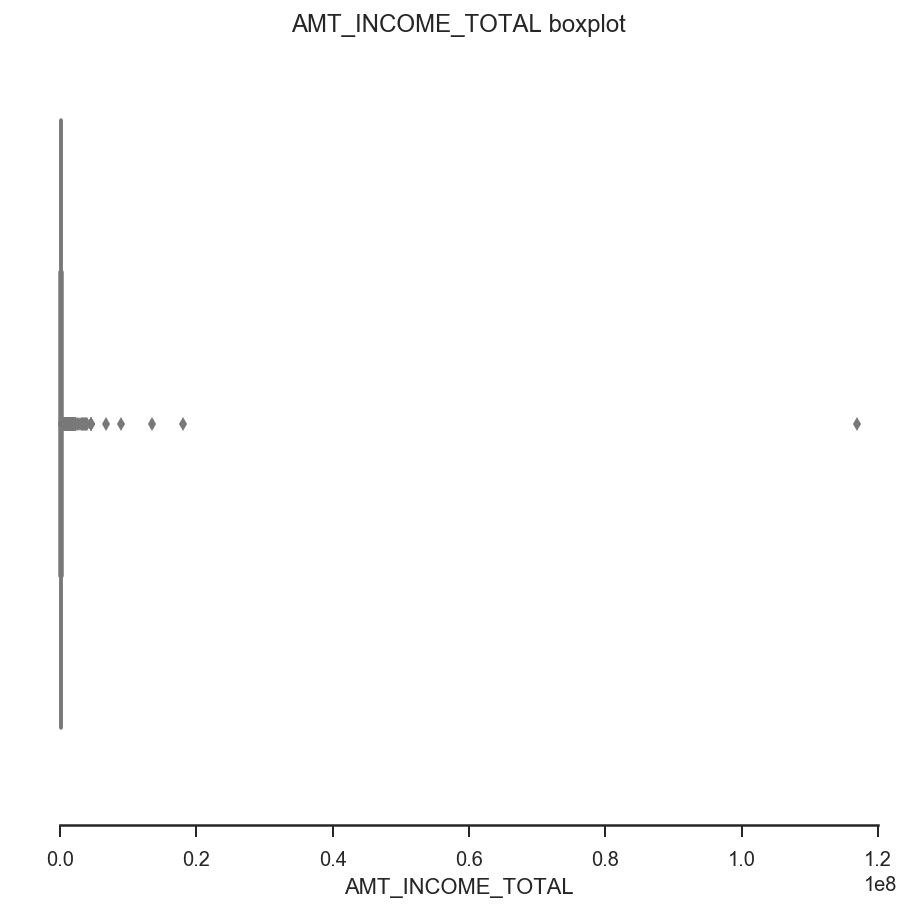

In [161]:
sns.boxplot(x="AMT_INCOME_TOTAL", data=train)
sns.despine(offset=10, trim=True)
plt.title("AMT_INCOME_TOTAL boxplot")

看来收入为1个多亿的人只有一个，不知道是否是录入错误，先暂时不管。

接下来看看DAYS_EMPLOYED，这个字段表示申请人相对于申请日之前的工作天数，用负数表示  
然而，居然有工作时间超过了3万天，粗略算一下就是100年！  
这肯定是数据错误

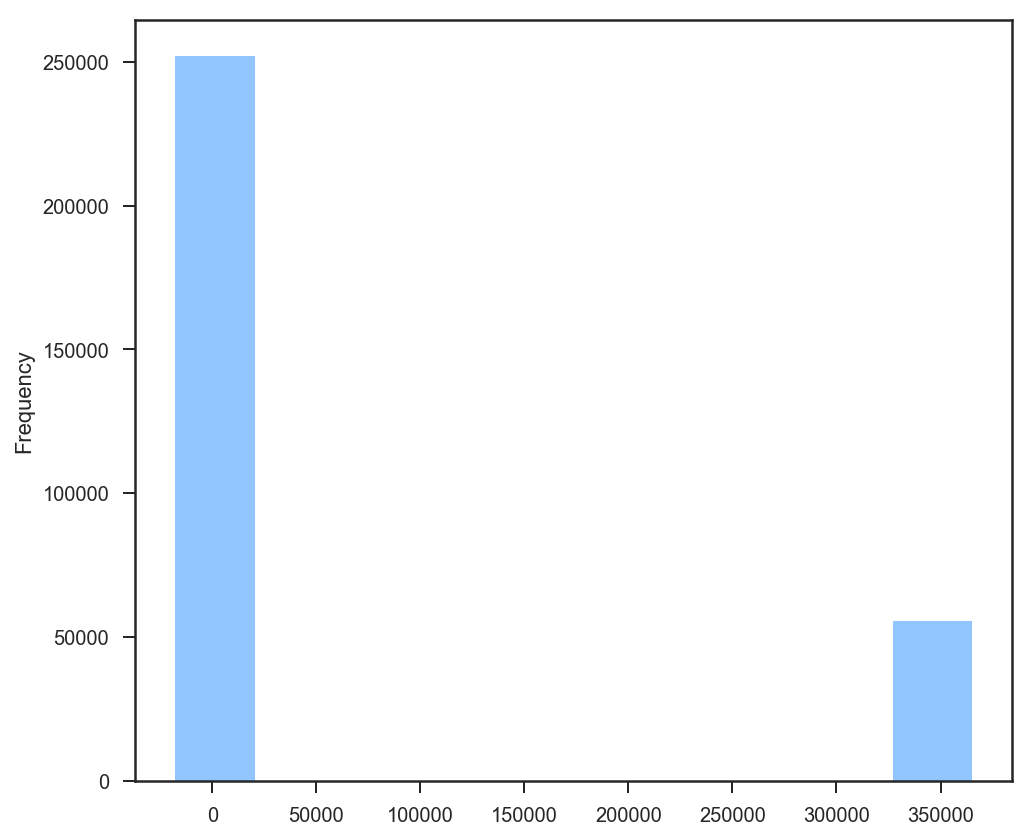

In [162]:
train['DAYS_EMPLOYED'].plot.hist()

In [185]:
train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

In [168]:
train2[['DAYS_EMPLOYED']].query('DAYS_EMPLOYED >= 300000').head()

,DAYS_EMPLOYED
8,365243
11,365243
23,365243
38,365243
43,365243


In [182]:
train2.loc[train2.DAYS_EMPLOYED >= 300000, 'DAYS_EMPLOYED'].value_counts()

365243    55374
Name: DAYS_EMPLOYED, dtype: int64

错误的数据都是365243，所以我们可以把错误的数据单独用一列标记出来，然后把原来的错误数据用np.nan填充。

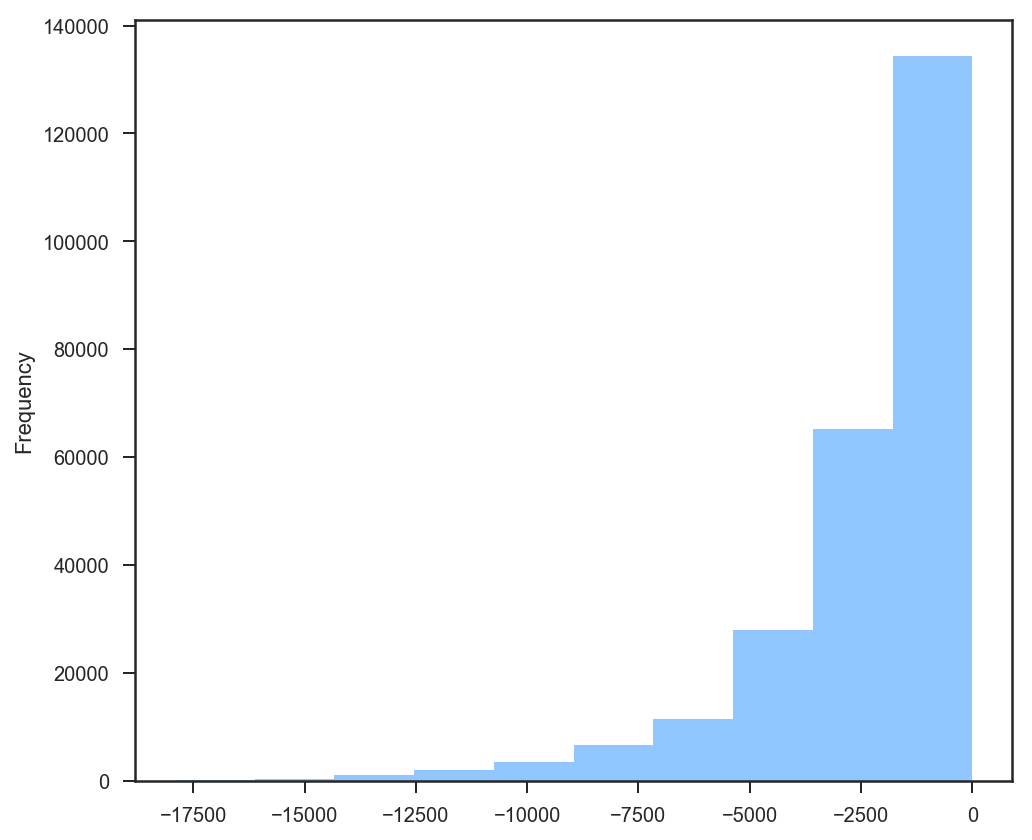

In [183]:
train2['DAYS_EMPLOYED_anom'] = train2['DAYS_EMPLOYED'] == 365243
train2['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)
train2['DAYS_EMPLOYED'].plot.hist()

按年表示：

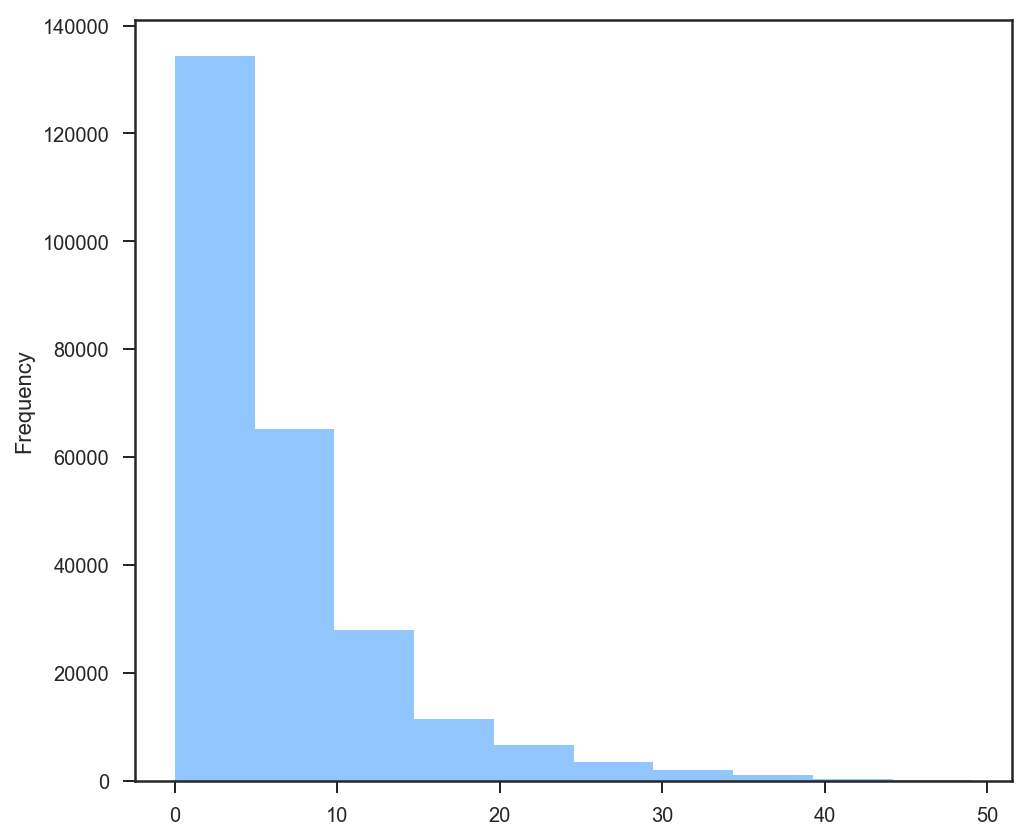

In [186]:
(train2['DAYS_EMPLOYED'] / -365).plot.hist()

基本没毛病

我们对测试集做同样的调整

In [187]:
test2['DAYS_EMPLOYED_anom'] = test2['DAYS_EMPLOYED'] == 365243
test2['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)

In [188]:
train2['CNT_FAM_MEMBERS'].describe()

count    307509.000000
mean          2.152665
std           0.910682
min           1.000000
25%           2.000000
50%           2.000000
75%           3.000000
max          20.000000
Name: CNT_FAM_MEMBERS, dtype: float64

其他字段似乎没啥毛病

## correlations相关性检查

In [193]:
corrs = train2.corr()

In [196]:
corrs['TARGET'].sort_values(ascending=False).head()

TARGET                         1.000000
DAYS_BIRTH                     0.078239
DAYS_EMPLOYED                  0.074958
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
Name: TARGET, dtype: float64

In [197]:
corrs['TARGET'].sort_values(ascending=False).tail()

CODE_GENDER_F                          -0.054704
NAME_EDUCATION_TYPE_Higher education   -0.056593
EXT_SOURCE_1                           -0.155317
EXT_SOURCE_2                           -0.160472
EXT_SOURCE_3                           -0.178919
Name: TARGET, dtype: float64

看起来所有特征与TARGET的相关性都不算特别强

### 年龄对违约的影响

In [200]:
# 因为年龄是以负数记录的，所谓我们把它调整为正数
age_train = abs(train2['DAYS_BIRTH'])
age_corr = age_train.corr(train2['TARGET'])

In [201]:
print(f"年龄与违约的相关系数为：{age_corr}")

年龄与违约的相关系数为：-0.07823930830982709


我们把年龄的分布画出来

Text(0, 0.5, '频数')

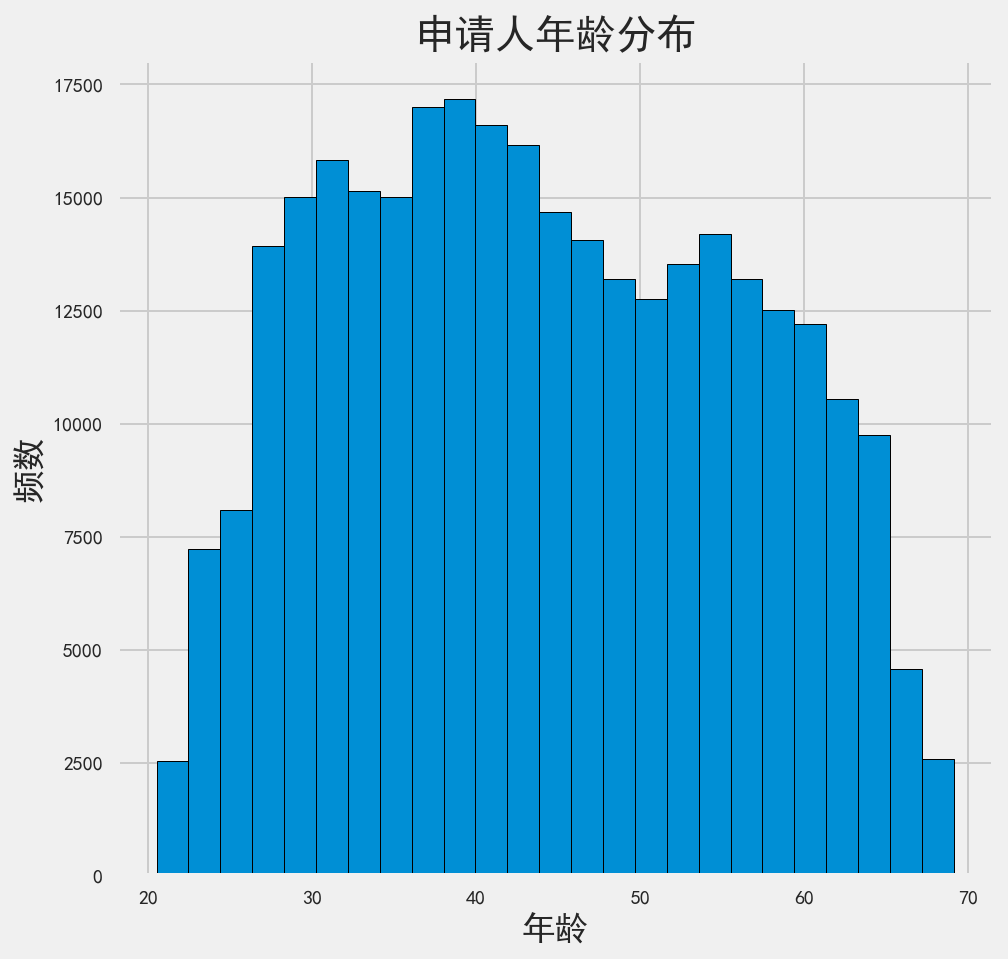

In [205]:
plt.style.use('fivethirtyeight')
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

plt.hist(age_train / 365, edgecolor='k', bins=25)
plt.title(u"申请人年龄分布")
plt.xlabel(u"年龄")
plt.ylabel(u"频数")

我们再按照是否违约，把申请人分成两部分，分别绘制分布图

(0, 0.04)

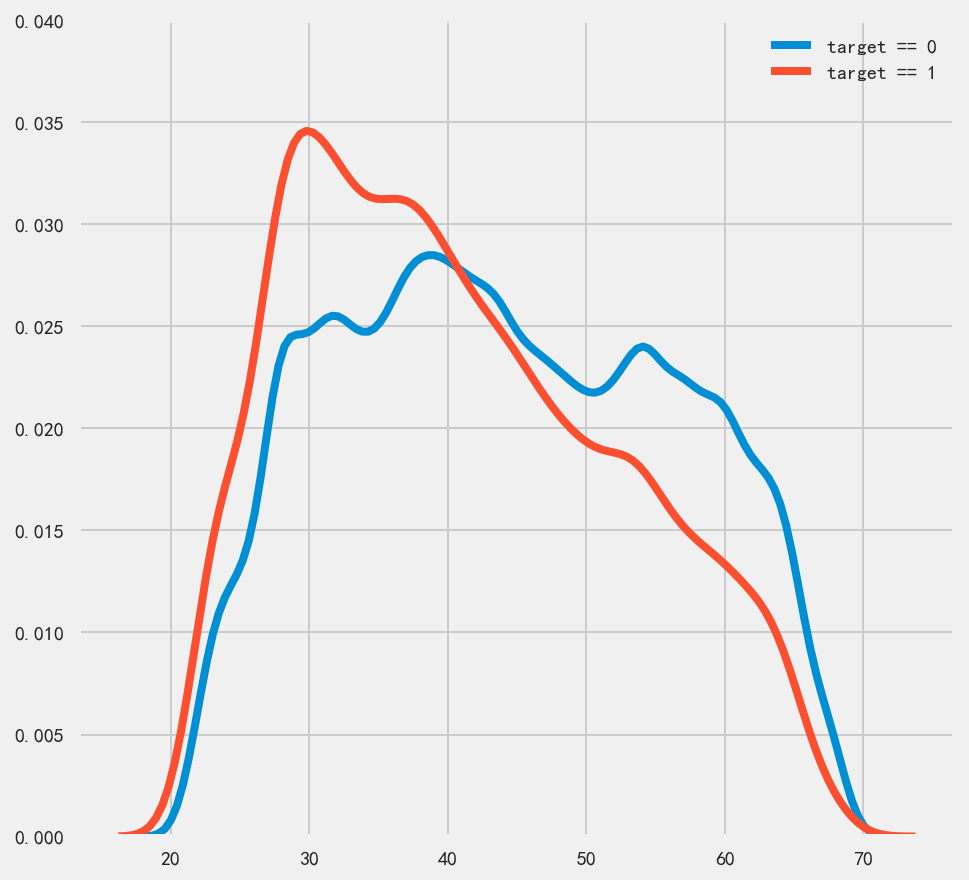

In [213]:
for i in [0, 1]:
    sns.kdeplot(age_train[train2['TARGET']==i] / 365, label = "target == %d" % i)
plt.ylim(0, 0.04)

可以看出违约人群偏向于年轻人

再来看看违约率随年龄的变化情况

In [221]:
age_train = (train2[['TARGET', 'DAYS_BIRTH']]
             .pipe(def (df) -> df['YEARS_BIRTH'] = (df['DAYS_BIRTH'] |> abs) / 365; df ))
age_train.head()

,TARGET,DAYS_BIRTH,YEARS_BIRTH
0,1,-9461,25.920548
1,0,-16765,45.931507
2,0,-19046,52.180822
3,0,-19005,52.068493
4,0,-19932,54.608219


In [222]:
age_train['YEARS_BIN'] = pd.cut(age_train['YEARS_BIRTH'], bins= np.linspace(20, 70, 11))
age_train.head()

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BIN
0,1,-9461,25.920548,"(25.0, 30.0]"
1,0,-16765,45.931507,"(45.0, 50.0]"
2,0,-19046,52.180822,"(50.0, 55.0]"
3,0,-19005,52.068493,"(50.0, 55.0]"
4,0,-19932,54.608219,"(50.0, 55.0]"


In [223]:
age_groups = age_train.groupby('YEARS_BIN').mean()

In [224]:
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BIN,,,
"(20.0, 25.0]",0.123036,-8532.795625,23.377522
"(25.0, 30.0]",0.111436,-10155.219250,27.822518
"(30.0, 35.0]",0.102814,-11854.848377,32.479037
"(35.0, 40.0]",0.089414,-13707.908253,37.555913
"(40.0, 45.0]",0.078491,-15497.661233,42.459346
"(45.0, 50.0]",0.074171,-17323.900441,47.462741
"(50.0, 55.0]",0.066968,-19196.494791,52.593136
"(55.0, 60.0]",0.055314,-20984.262742,57.491131
"(60.0, 65.0]",0.052737,-22780.547460,62.412459


Text(0.5, 1.0, '违约率随年龄变化')

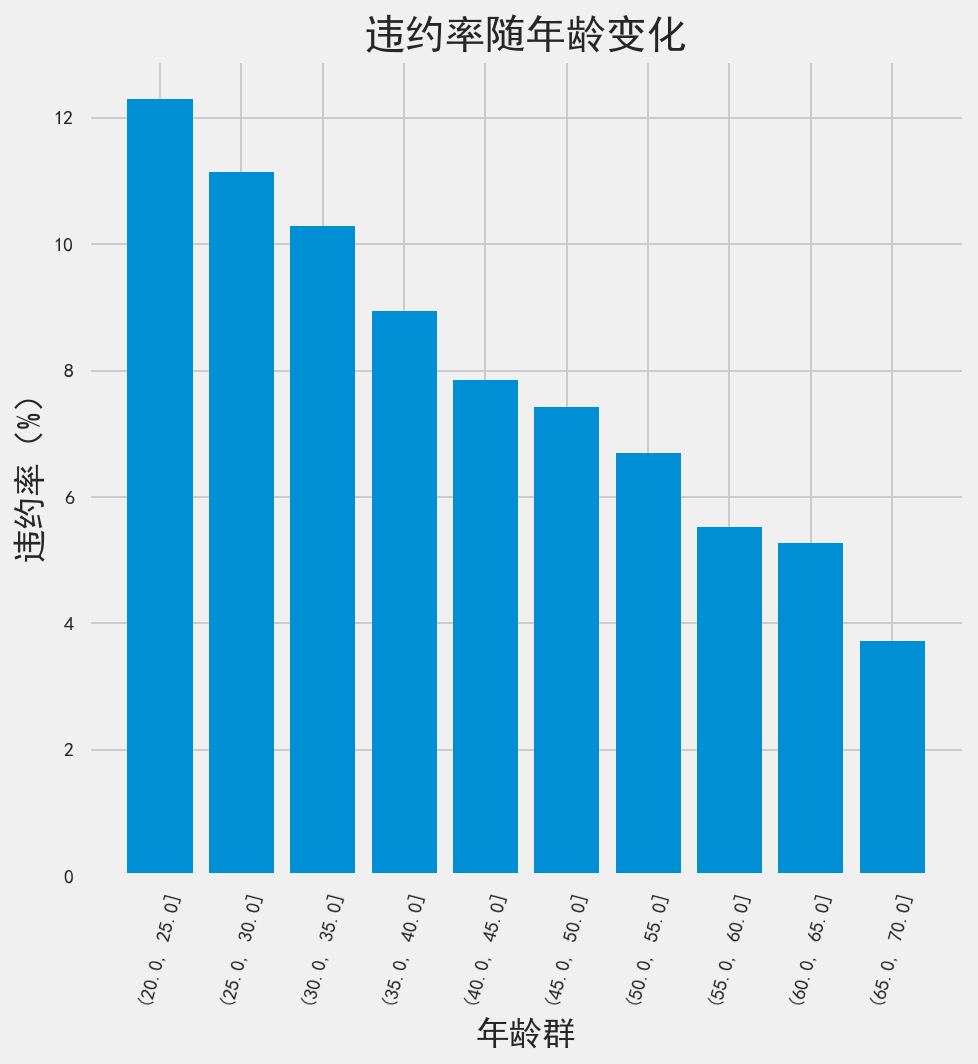

In [226]:
plt.bar(age_groups.index.astype(str), 100 * age_groups.TARGET)
plt.xticks(rotation=75)
plt.xlabel("年龄群")
plt.ylabel("违约率（%）")
plt.title("违约率随年龄变化")

可以清楚的看到，违约率随年龄的增长而降低，也就是说越年轻的人越容易违约，越老的人反而不容易违约。  
可能年轻人没有啥储蓄，消费又高吧，想想花呗、借呗🤣

### EXT_SOURCE 1、2、3 外部数据

EXT_SOURCE_1、EXT_SOURCE_2、EXT_SOURCE_3是与TARGET负相关性最强的三个变量

我们来研究一下

In [229]:
ext_train = train2[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']]
ext_corr = ext_train.corr()
ext_corr

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
TARGET,1.000000,-0.155317,-0.160472,-0.178919
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000


Text(0.5, 1.0, '相关性热力图')

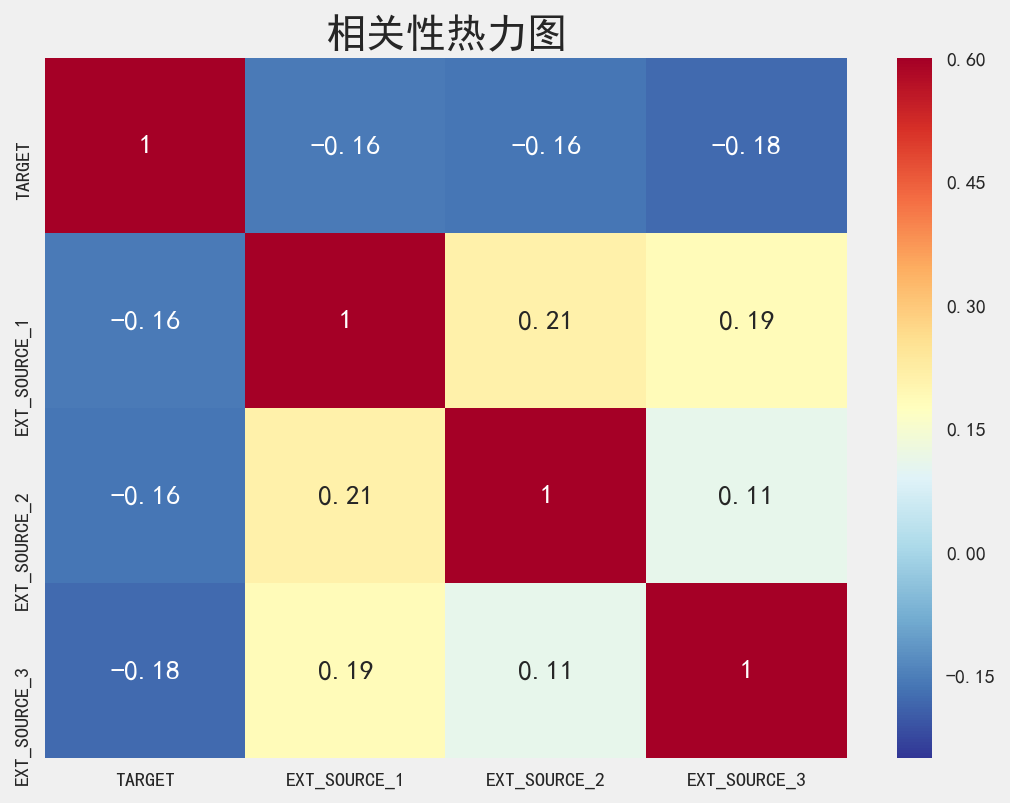

In [233]:
figsize(8, 6)
sns.heatmap(ext_corr, cmap=plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title("相关性热力图")

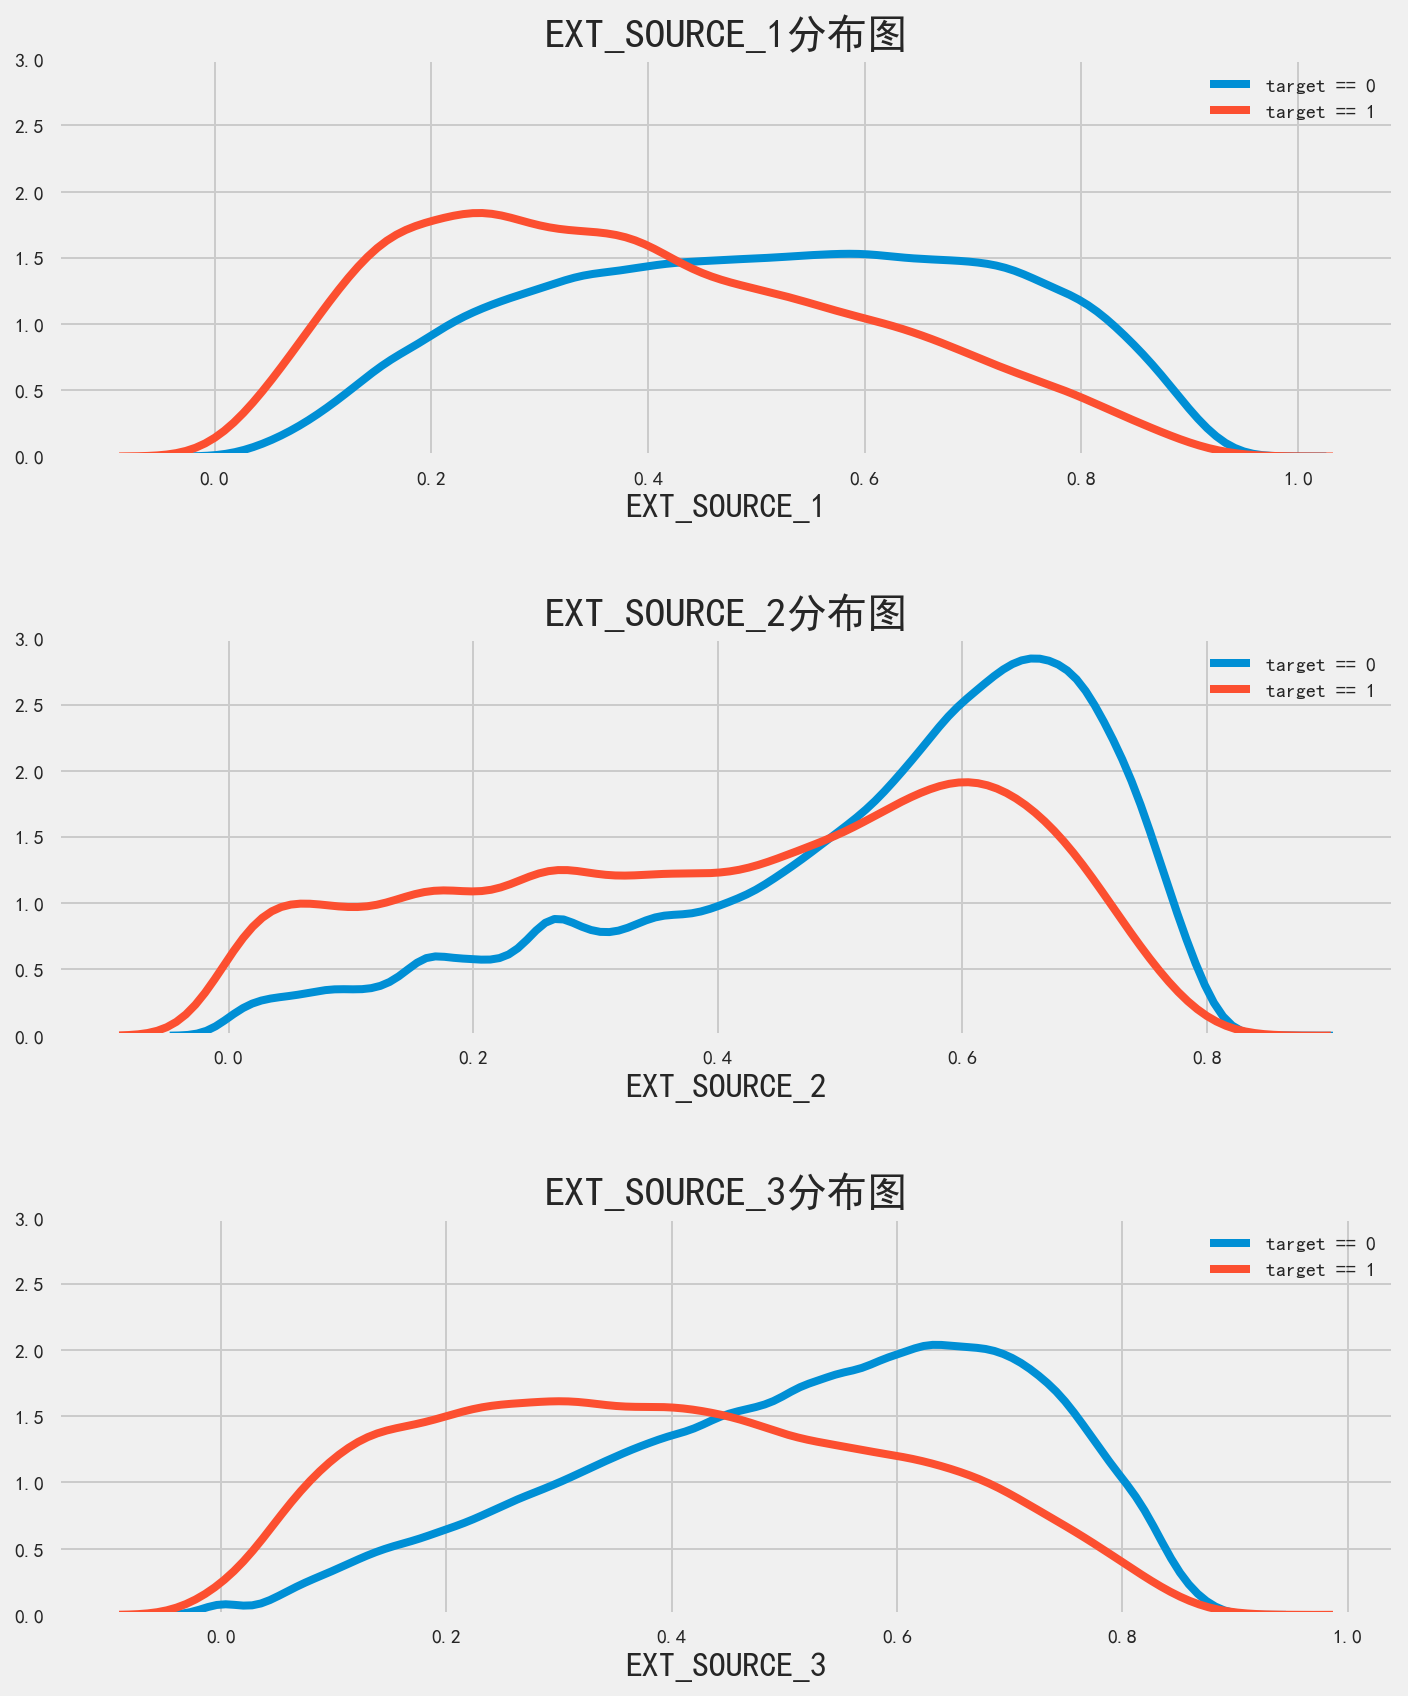

In [239]:
figsize(10,12)
for i, ext in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    plt.subplot(3, 1, i + 1)
    sns.kdeplot(ext_train.loc[ext_train.TARGET == 0, ext], label = "target == 0")
    sns.kdeplot(ext_train.loc[ext_train.TARGET == 1, ext], label = "target == 1")
    plt.title(f"{ext}分布图")
    plt.xlabel(ext)
    plt.ylim(0, 3)
plt.tight_layout(h_pad = 2.5)

EXT_SOURCE_3最有区分度，违约和没有违约的评分分布在头尾两侧，  
其次是EXT_SOURCE_1， EXT_SOURCE_2则表现的不明显

## 特征工程

### Polynomial Features

我们选择对'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'和DAYS_BIRTH进行多项式特征工程

In [240]:
poly_fea_train = train2[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3','DAYS_BIRTH']]
poly_fea_test = test2[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3','DAYS_BIRTH']]

In [241]:
# 处理缺失值
import sklearn
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy='median') # 采取中位数填充更稳健

poly_fea_train = imputer.fit_transform(poly_fea_train)
poly_fea_test = imputer.fit_transform(poly_fea_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [250]:
# 多项式特征工程
from sklearn.preprocessing import PolynomialFeatures

poly_transformer = PolynomialFeatures(degree=3)
poly_transformer.fit(poly_fea_train)

poly_fea_train = poly_transformer.transform(poly_fea_train)
poly_fea_test = poly_transformer.transform(poly_fea_test)

In [251]:
poly_fea_train.shape

(307511, 35)

查看生成的多项式特征

In [253]:
poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3','DAYS_BIRTH'])

['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2',
 'EXT_SOURCE_1^3',
 'EXT_SOURCE_1^2 EXT_SOURCE_2',
 'EXT_SOURCE_1^2 EXT_SOURCE_3',
 'EXT_SOURCE_1^2 DAYS_BIRTH',
 'EXT_SOURCE_1 EXT_SOURCE_2^2',
 'EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_1 EXT_SOURCE_3^2',
 'EXT_SOURCE_1 EXT_SOURCE_3 DAYS_BIRTH',
 'EXT_SOURCE_1 DAYS_BIRTH^2',
 'EXT_SOURCE_2^3',
 'EXT_SOURCE_2^2 EXT_SOURCE_3',
 'EXT_SOURCE_2^2 DAYS_BIRTH',
 'EXT_SOURCE_2 EXT_SOURCE_3^2',
 'EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH',
 'EXT_SOURCE_2 DAYS_BIRTH^2',
 'EXT_SOURCE_3^3',
 'EXT_SOURCE_3^2 DAYS_BIRTH',
 'EXT_SOURCE_3 DAYS_BIRTH^2',
 'DAYS_BIRTH^3']

接下来看看多项式特征与TARGET间的相关性

In [254]:
poly_fea_train = pd.DataFrame(
    poly_fea_train,
    columns=(poly_transformer
             .get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3','DAYS_BIRTH']))
)

In [256]:
poly_fea_train = pd.concat([poly_fea_train, train2[['TARGET']]], axis=1)
poly_fea_corr = poly_fea_train.corr()['TARGET'].sort_values(ascending=False)
poly_fea_corr.head(10)

TARGET                                  1.000000
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH    0.181283
EXT_SOURCE_2 DAYS_BIRTH                 0.156873
EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH    0.155891
EXT_SOURCE_1 EXT_SOURCE_3 DAYS_BIRTH    0.151816
EXT_SOURCE_3 DAYS_BIRTH                 0.150109
EXT_SOURCE_2^2 DAYS_BIRTH               0.149313
EXT_SOURCE_3^2 DAYS_BIRTH               0.141777
EXT_SOURCE_1 DAYS_BIRTH                 0.104882
EXT_SOURCE_1^2 DAYS_BIRTH               0.097507
Name: TARGET, dtype: float64

In [258]:
poly_fea_corr.tail(10)

EXT_SOURCE_3                             -0.155892
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
1                                              NaN
Name: TARGET, dtype: float64

In [260]:
train2.shape

(307511, 241)

我们把多项式特征加回原数据框

In [261]:
poly_fea_test = pd.DataFrame(
    poly_fea_test,
    columns=(poly_transformer
             .get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3','DAYS_BIRTH']))
)

In [262]:
train2_poly = pd.concat([train2, poly_fea_train.drop('TARGET', axis=1)], axis=1)
test2_poly = pd.concat([test2, poly_fea_test], axis=1)

In [263]:
print(f"train2_poly shape: {train2_poly.shape}")
print(f"test2_poly shape: {test2_poly.shape}")

train2_poly shape: (307511, 276)
test2_poly shape: (48744, 275)


In [265]:
for col in train2_poly.columns:
    if col not in test2_poly.columns:
        print(col)

TARGET


###  Domain Knoledge Features 专业知识特征 

我们将根据专业知识衍生出以下几个特征：
- CREDIT_INCOME_PERCENT：信贷额度与收入之比
- ANNUITY_INCOME_PERCENT：年金贷款与收入之比
- CREDIT_TERM：年金贷款与授信额度之比
- DAYS_EMPLOYED_PERCENT：工作期限与年龄之比

In [267]:
train_domain = train2.copy()
test_domain = test2.copy()

In [268]:
def domain_features(df) =
    (df
     .assign(CREDIT_INCOME_PERCENT = df.AMT_CREDIT / df.AMT_INCOME_TOTAL)
     .assign(ANNUITY_INCOME_PERCENT = df.AMT_ANNUITY / df.AMT_INCOME_TOTAL)
     .assign(CREDIT_TERM = df.AMT_ANNUITY / df.AMT_CREDIT)
     .assign(DAYS_EMPLOYED_PERCENT = df.DAYS_EMPLOYED / df.DAYS_BIRTH)
    )
train_domain = train_domain.pipe(domain_features)
test_domain = test_domain.pipe(domain_features)

我们来对新特征绘图

In [276]:
def feat_plot(df, features) = 
    figsize(12, 20)
    for i, feat in enumerate(features):
        plt.subplot(len(features), 1, i + 1)
        sns.kdeplot(df.loc[df['TARGET']==0, feat], label="target == 0")
        sns.kdeplot(df.loc[df['TARGET']==1, feat], label="target == 1")
        plt.title("%s分布图" % feat)
    plt.axis('auto')
    plt.tight_layout(h_pad=2.5)

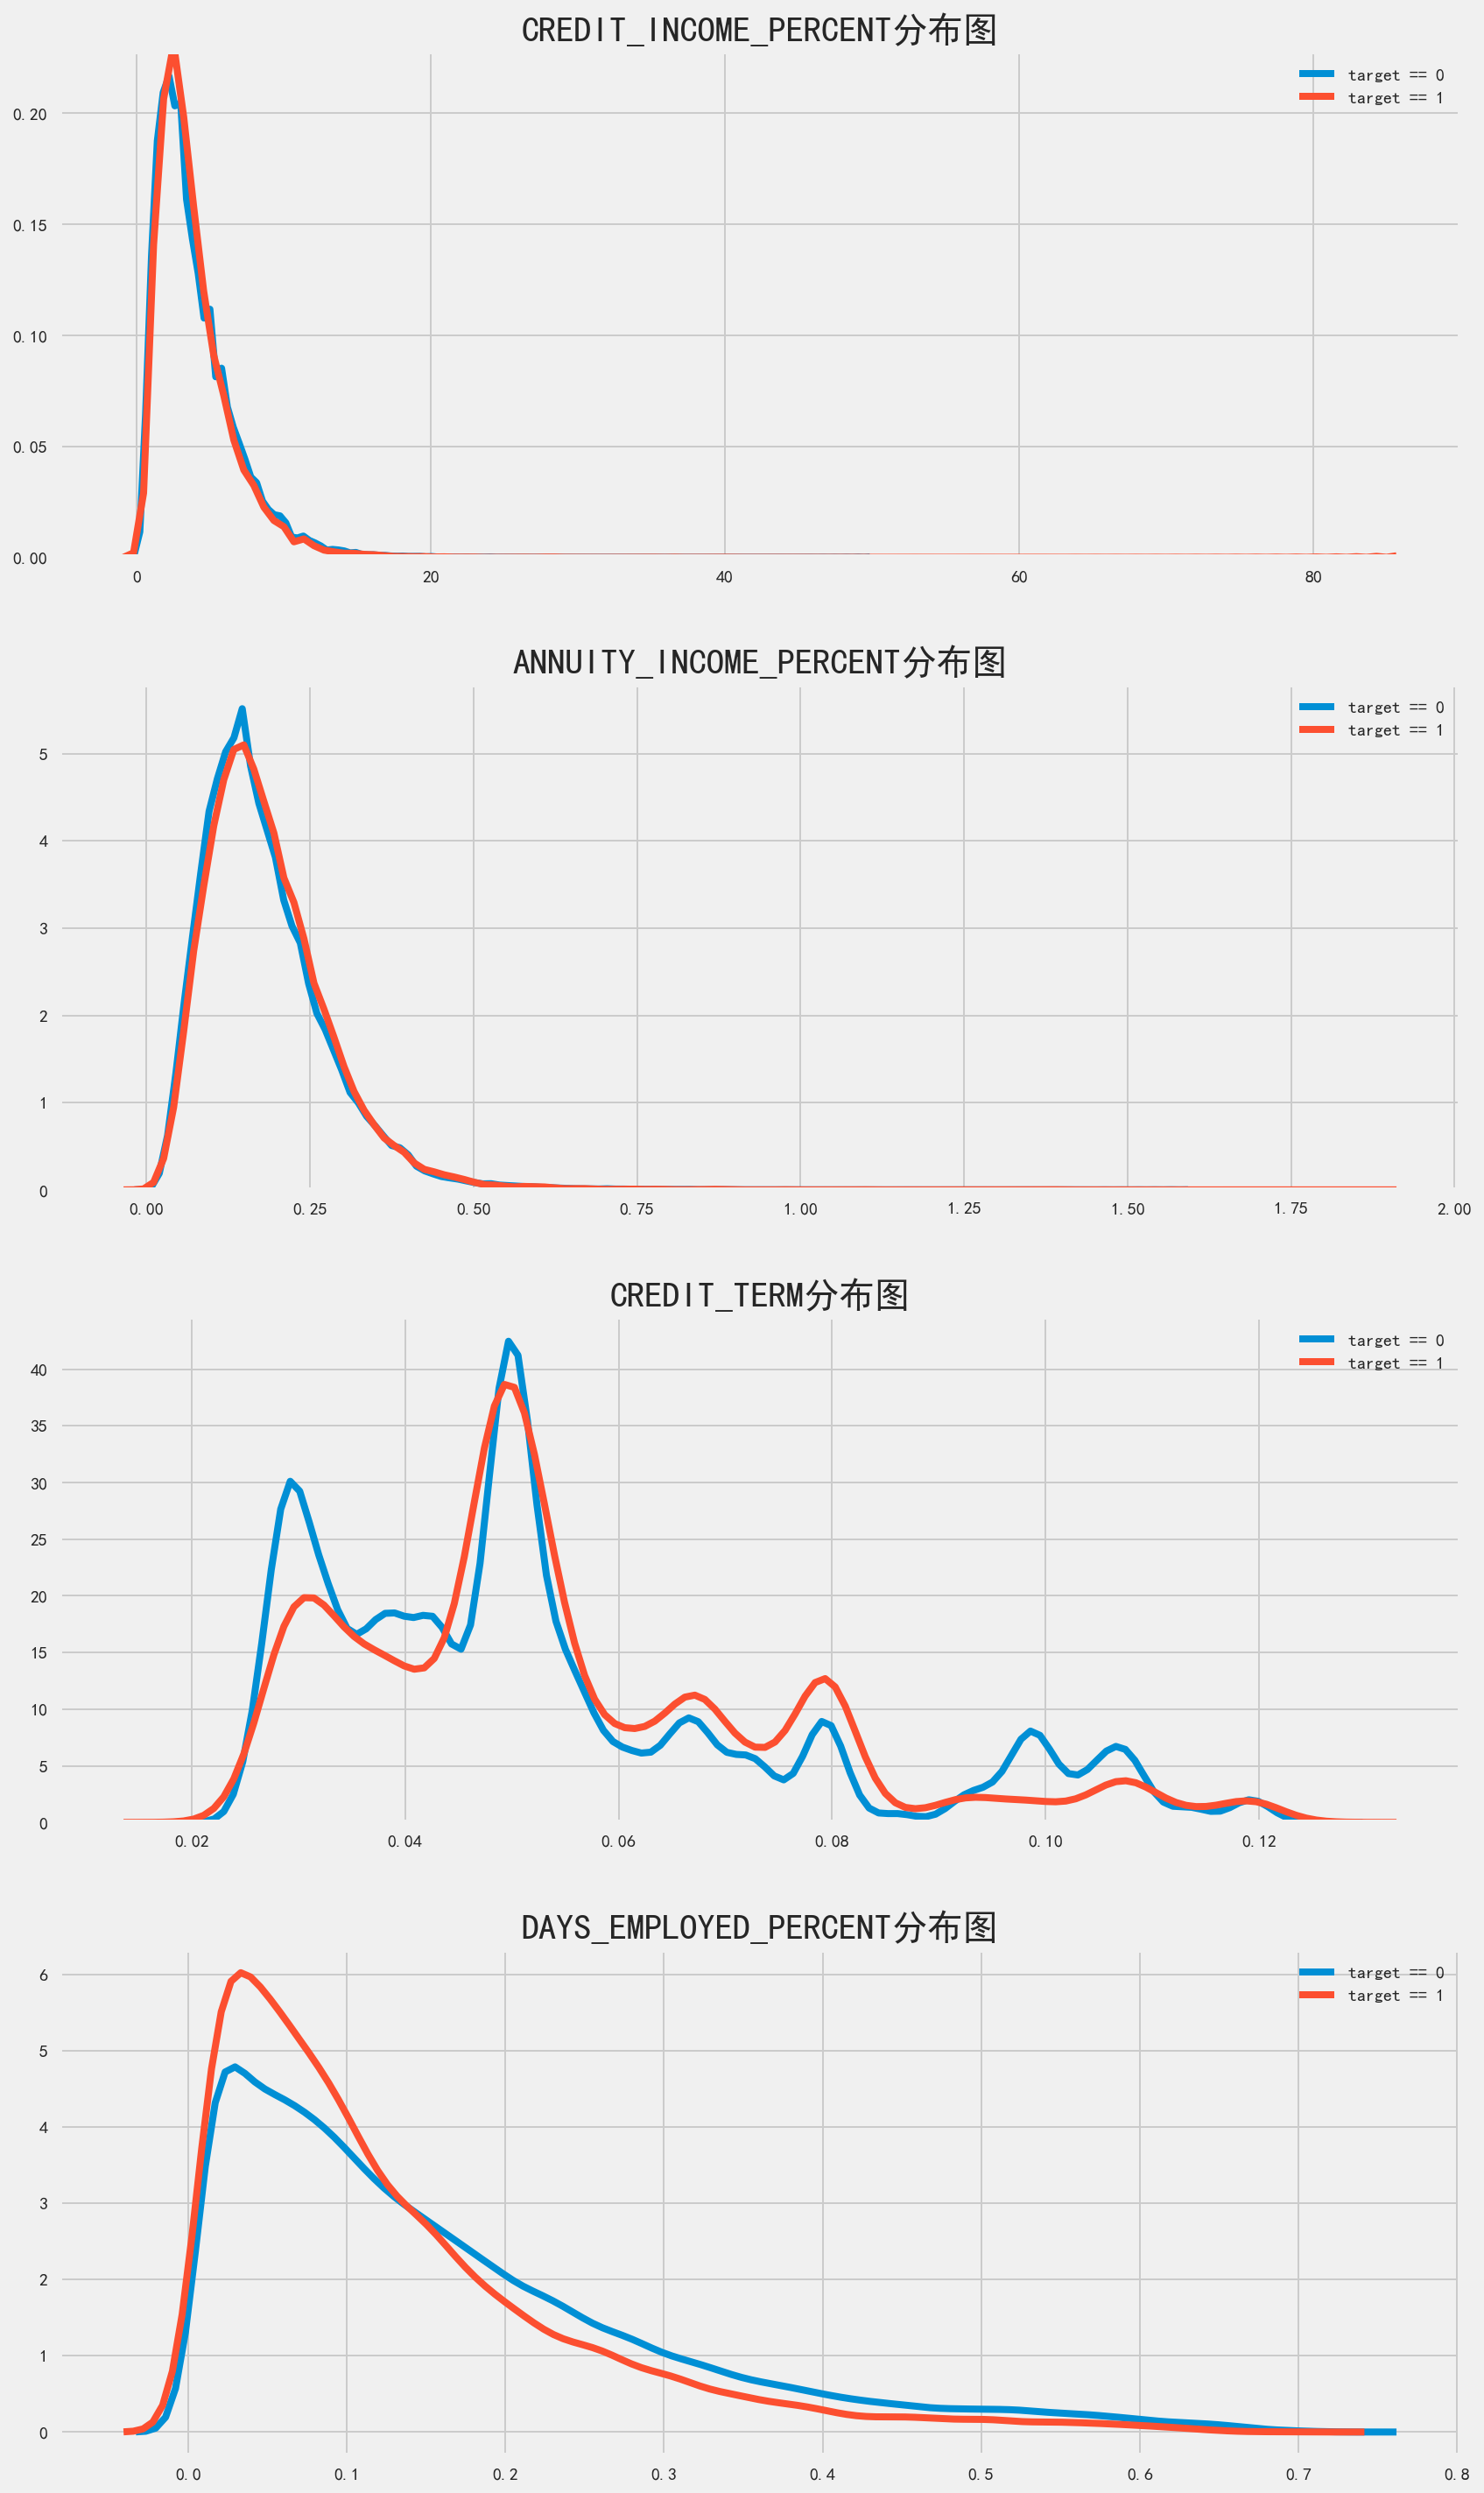

In [277]:
feat_plot(train_domain, 
          ['CREDIT_INCOME_PERCENT','ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT'])

从图形中似乎看不出这些新特征的效果

## 基准模型

我们选择logistic regression作为我们的基准模型，并使用未新增特征的数据集进行训练

得到的AUC将作为后续模型的比较基准

In [282]:
from sklearn.preprocessing import MinMaxScaler, Imputer

def preprocess_data(df_train, df_test):
    if 'TARGET' in df_train:
        train = df_train.drop('TARGET', axis=1).copy()
    else:
        train = df_train
    
    features = train.columns |> list
    
    test = df_test.copy()
    
    imputer = Imputer(strategy = 'median')
    scaler = MinMaxScaler(feature_range = (0, 1))
    
    imputer.fit(train)
    scaler.fit(train)
    train = train |> imputer.transform |> scaler.transform
    test = test |> imputer.transform |> scaler.transform
    
    print(f'training data shape: {train.shape}')
    print(f"testing data shape: {test.shape}")
    return train, test, features

In [283]:
X_train, X_test, features = preprocess_data(train2, test2)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype bool, uint8, int32, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


training data shape: (307511, 240)
testing data shape: (48744, 240)


In [285]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=0.0001)
lr.fit(X_train, train2['TARGET'])


LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [291]:
preds = lr.predict_proba(X_test)[:, 1]

In [292]:
submit = test2[['SK_ID_CURR']].assign(TARGET = preds)

In [293]:
submit.head()

,SK_ID_CURR,TARGET
0,100001,0.066677
1,100005,0.128855
2,100013,0.084450
3,100028,0.060502
4,100038,0.127878


In [294]:
submit.to_csv("logistic_regression_baseline.csv", index=False)

提交得分：  
public: 0.67628  
private: 0.68035

## lightGBM

这一部分，我们用lightGBM来拟合数据，以此对比我们的baseline

In [296]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import gc

y_train = train2_poly['TARGET']
X_train = train2_poly.drop('TARGET', axis=1).values
X_test = test2_poly.values   

In [298]:
lgb_train = lgb.Dataset(X_train, y_train)

# 敲定好一组参数
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'l2', 'auc'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

print('开始训练')
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                #early_stopping_rounds=5
               )
# 保存模型
print('保存模型...')
# 保存模型到文件中
gbm.save_model('lgb_model.txt')
print('开始预测...')
# 预测
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

开始训练
保存模型...
开始预测...


In [299]:
y_pred

array([0.07321019, 0.09329211, 0.04649348, ..., 0.06316655, 0.06532396,
       0.1420698 ])

In [301]:
submit_lgb = test2[['SK_ID_CURR']].assign(TARGET = y_pred)
submit_lgb.to_csv("lgb_submission.csv", index=False)

分数为：  
public: 0.72580  
private: 0.71848

In [306]:
y_train = train2_poly['TARGET']
X_train_domain = train_domain.drop(['TARGET','SK_ID_CURR'], axis=1).values
X_test_domain = test_domain.drop(['SK_ID_CURR'], axis=1).values   

lgb_train = lgb.Dataset(X_train_domain, y_train)

# 敲定好一组参数
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'l2', 'auc'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

print('开始训练')
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                #early_stopping_rounds=5
               )
# 保存模型
print('保存模型...')
# 保存模型到文件中
gbm.save_model('lgb_model_domain.txt')
print('开始预测...')
# 预测
y_pred_domain = gbm.predict(X_test_domain, num_iteration=gbm.best_iteration)
submit_lgb_domain = test2[['SK_ID_CURR']].assign(TARGET = y_pred_domain)
submit_lgb_domain.to_csv("lgb_submission.csv", index=False)

开始训练
保存模型...
开始预测...


分数为：  
public: 0.72618  
private: 0.71842